In [173]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set()

Working with numeric variables first

In [174]:
conn = sqlite3.connect("champion_riot.sqlite")
cur = conn.cursor()

In [175]:
# all tables in the database champion_riot_sqlite
pd.read_sql_query("""SELECT name FROM sqlite_master
                     WHERE type='table'
                     ORDER BY name;""", conn)

,name
0,allytips
1,blurb
2,enemytips
3,format
4,info
5,partype
6,passive
7,skins
8,spells
9,stats


In [176]:
df = pd.read_sql_query("""SELECT a.title, a.id, a.name, b.difficulty, b.attack, b.defense, b.magic
                          FROM allytips a 
                          LEFT JOIN (SELECT * FROM info) b 
                          ON a.id = b.id""", conn)

In [177]:
# a total of 137 champions are currently in the game
df.shape

(137, 7)

In [178]:
# all info ranges from 1 to 10
df[["difficulty","attack","defense","magic"]].aggregate(["min","mean","median","max"])

,difficulty,attack,defense,magic
min,1.000000,1.000000,1.000000,1.000000
mean,5.751825,5.540146,4.773723,5.423358
median,6.000000,6.000000,5.000000,6.000000
max,10.000000,10.000000,10.000000,10.000000


In [179]:
df[["difficulty","attack","defense","magic"]].corr(method='pearson')

,difficulty,attack,defense,magic
difficulty,1.000000,-0.194008,-0.310971,0.308174
attack,-0.194008,1.000000,-0.178120,-0.828016
defense,-0.310971,-0.178120,1.000000,-0.131800
magic,0.308174,-0.828016,-0.131800,1.000000


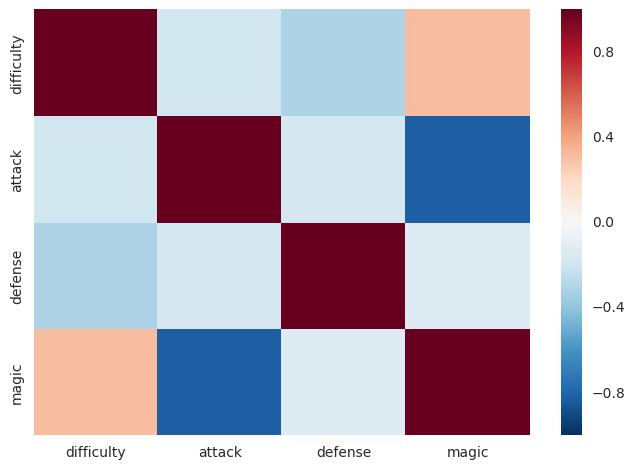

In [180]:
sns.heatmap(df[["difficulty","attack","defense","magic"]].corr(method='pearson'))
plt.show()

In [181]:
print(scipy.stats.pearsonr(df["difficulty"], df["attack"])) # significant weak negative correlation
print(scipy.stats.pearsonr(df["difficulty"], df["defense"])) # significant weak negative correlation
print(scipy.stats.pearsonr(df["difficulty"], df["magic"])) # significant weak positive correlation

(-0.19400783573555302, 0.023109157613865467)
(-0.31097050809761989, 0.00021679150909228914)
(0.3081741957747251, 0.00024867946587844831)


In [182]:
print(scipy.stats.pearsonr(df["attack"], df["defense"])) # significant weak negative correlation
print(scipy.stats.pearsonr(df["attack"], df["magic"])) # significant strong negative correlation

(-0.17811991342786959, 0.03730409391972505)
(-0.82801553843011422, 9.9003928907948432e-36)


In [183]:
print(scipy.stats.pearsonr(df["defense"], df["magic"])) # Not significant weak negative correlation

(-0.13179968744554141, 0.1247233505738516)


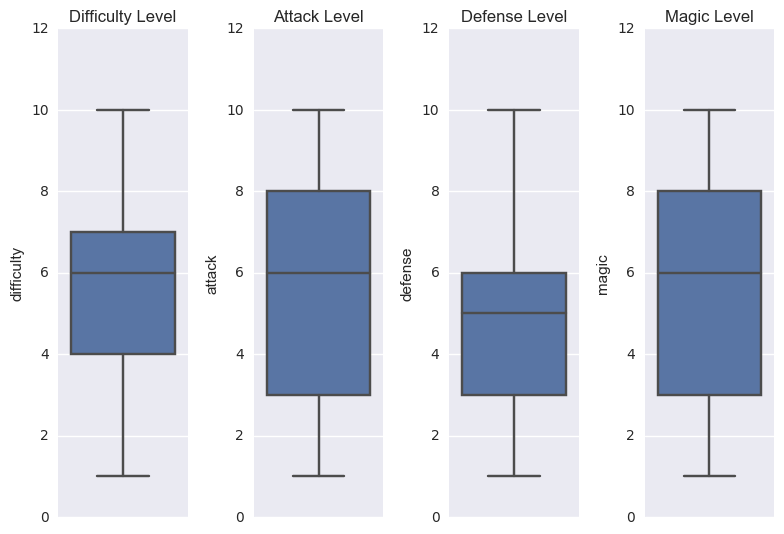

In [184]:
plt.subplot(1, 4, 1)
plt.title("Difficulty Level")
sns.boxplot(df["difficulty"],orient = "v")
plt.ylim([0 , 12])
plt.subplot(1, 4, 2)
plt.title("Attack Level")
sns.boxplot(df["attack"],orient = "v")
plt.ylim([0 , 12])
plt.subplot(1, 4, 3)
plt.title("Defense Level")
sns.boxplot(df["defense"],orient = "v")
plt.ylim([0 , 12])
plt.subplot(1, 4, 4)
plt.title("Magic Level")
sns.boxplot(df["magic"],orient = "v")
plt.ylim([0 , 12])
plt.tight_layout()
plt.show()

Difficulty, attack, defense, and magic levels were all on a scale of 1 to 10. difficulty, attack, and magic had a medium around 6, while defense has the lowest medium at 5 - the distribution of defense was also lowered than the others. Defense and difficulty levels were negatively associated with each other (-0.31). Difficulty was positively related to magic (0.31). Attack was strongly negatively associated with magic (-0.83). Only difficulty and magic is negatively correlated with each other. 

In [185]:
# all champions have a format of full - skip format
pd.read_sql_query("""SELECT * FROM format""", conn)["format"].value_counts()

full    137
Name: format, dtype: int64

In [186]:
# partype data 
df1 = pd.read_sql_query("""SELECT * FROM partype""", conn)

In [187]:
df1.head(3)

,partype,id
0,Mana,1
1,Mana,10
2,Mana,101


In [188]:
graph = df1["partype"].value_counts().reset_index()

In [189]:
graph["percent"] = graph["partype"]/137.*100

In [190]:
graph

,index,partype,percent
0,Mana,115,83.941606
1,Energy,5,3.649635
2,None,5,3.649635
3,Fury,4,2.919708
4,Blood Well,1,0.729927
5,Flow,1,0.729927
6,Ferocity,1,0.729927
7,Heat,1,0.729927
8,Rage,1,0.729927
9,Crimson Rush,1,0.729927


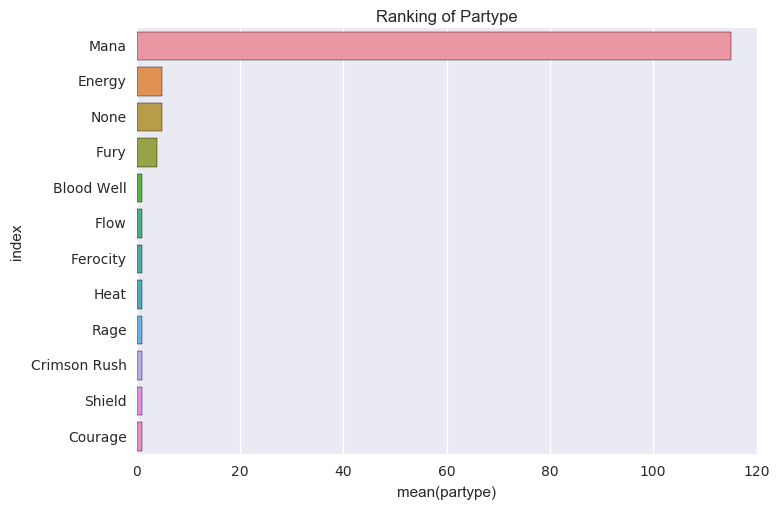

In [191]:
sns.barplot(y = "index", x = "partype", data = graph, orient = "h")
plt.title("Ranking of Partype")
plt.show()

The most prevalent types were mana (84%), energy (4%), none (4%), and fury (3%). All other types only had one hero (< 1%)

In [192]:
df = pd.merge(df, df1, how = "inner", on = "id")

In [193]:
df2 = pd.read_sql_query("""SELECT id, no_skins FROM skins""", conn)

In [194]:
df2["no_skins"].aggregate(["min","mean","median","max"])

min        2.000000
mean       6.671533
median     7.000000
max       11.000000
Name: no_skins, dtype: float64

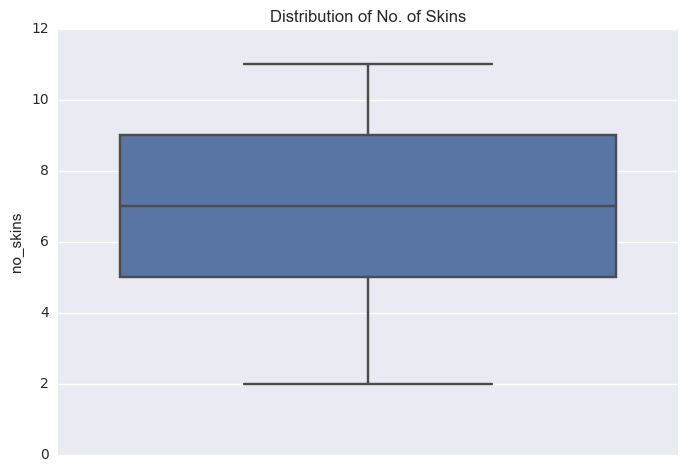

In [195]:
sns.boxplot(y = "no_skins", data = df2)
plt.ylim([0,12])
plt.title("Distribution of No. of Skins")
plt.show()

In [196]:
df = pd.merge(df, df2, how = "inner", on = "id")

In [197]:
df.head(2)

,title,id,name,difficulty,attack,defense,magic,partype,no_skins
0,the Dark Child,1,Annie,6,2,3,10,Mana,11
1,The Judicator,10,Kayle,7,6,6,7,Mana,9


On average, each character has 7 skins. The no ranges from 2 to 11. 

In [213]:
df3 = pd.read_sql_query("""SELECT *
                           FROM spells""", conn)

In [214]:
list(df3)
# starting stats: attack damage, mp, armor, hp, attack range, move speed, crit, mpregen, 
# spellblock, hpreg, attackspeed offset
# leveling up stats: attackdamagerperlevel, mpperlevel, armorperlevel, hpperlevel, critperlevel, 
# mpregenperlevel, spellblockperlevel, hpregperlvel, attackspeedperlevel

['id',
 'armorperlevel',
 'attackdamage',
 'mpperlevel',
 'attackspeedoffset',
 'mp',
 'armor',
 'hp',
 'hpregenperlevel',
 'attackspeedperlevel',
 'attackrange',
 'movespeed',
 'attackdamageperlevel',
 'mpregenperlevel',
 'critperlevel',
 'spellblockperlevel',
 'crit',
 'mpregen',
 'spellblock',
 'hpregen',
 'hpperlevel']

In [217]:
# HP - hp, hpperleevel, hpregen, hprenperlel
df3[["hp","hpperlevel","hpregen","hpregenperlevel"]].aggregate(["min","median","mean","max"])

,hp,hpperlevel,hpregen,hpregenperlevel
min,340.000000,65.000000,2.50000,0.300000
median,550.000000,85.000000,6.92400,0.600000
mean,549.363796,84.337591,6.88762,0.656934
max,625.640000,106.000000,10.18000,1.750000


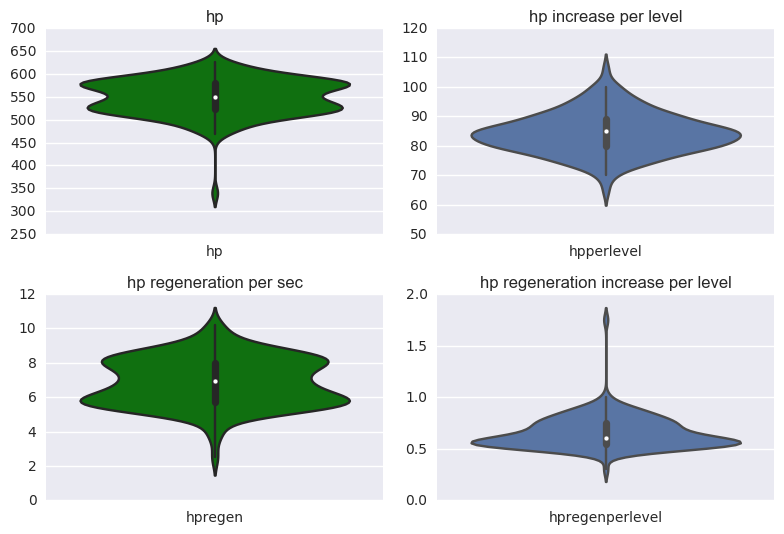

In [268]:
plt.subplot(2,2,1)
plt.title("hp")
sns.violinplot(df3[["hp"]],color = "green")
plt.subplot(2,2,2)
plt.title("hp increase per level")
sns.violinplot(df3[["hpperlevel"]])
plt.subplot(2,2,3)
plt.title("hp regeneration per sec")
sns.violinplot(df3[["hpregen"]], color = "green")
plt.subplot(2,2,4)
plt.title("hp regeneration increase per level")
sns.violinplot(df3[["hpregenperlevel"]])
plt.tight_layout()
plt.show()

In [269]:
HP = df3[["hp","hpperlevel","hpregen","hpregenperlevel"]]
HP.corr(method='pearson')

,hp,hpperlevel,hpregen,hpregenperlevel
hp,1.000000,0.682190,0.552504,0.309702
hpperlevel,0.682190,1.000000,0.474542,0.221856
hpregen,0.552504,0.474542,1.000000,0.365545
hpregenperlevel,0.309702,0.221856,0.365545,1.000000


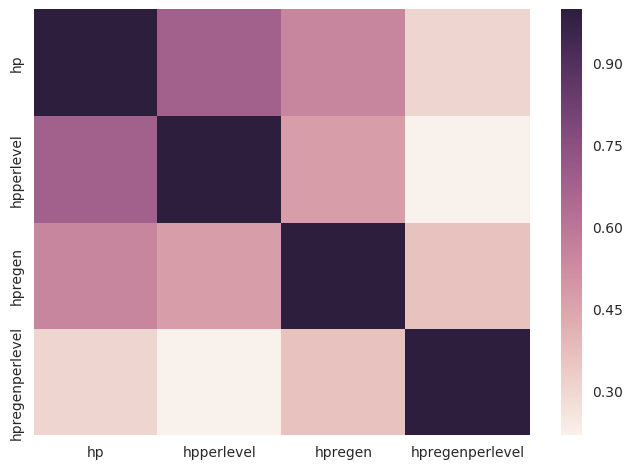

In [297]:
sns.heatmap(HP.corr(method='pearson'))
plt.show()

In [295]:
def correlation_p_value(data):
    a = [(x, y) for x in list(data) for y in list(data) if x != y]
    compare = list()
    for (x,y) in a:
        if (x, y) not in compare and (y, x) not in compare:
            compare.append((x, y))
    for (x, y) in compare:
        print x + " and " + y
        print scipy.stats.pearsonr(data[x], data[y])
        print "="*50

In [296]:
correlation_p_value(HP)

hp and hpperlevel
(0.6821900765410025, 4.378891792773511e-20)
hp and hpregen
(0.5525044891600337, 2.5683036444474798e-12)
hp and hpregenperlevel
(0.30970170339984615, 0.00023075828682034337)
hpperlevel and hpregen
(0.47454247987692116, 4.6778491164153352e-09)
hpperlevel and hpregenperlevel
(0.2218561078212575, 0.0091734961141551902)
hpregen and hpregenperlevel
(0.36554459795822664, 1.1211707508660931e-05)


All HP stats are positively and significantly correlated with each other. The range of starting HP varies widely (350 - 625). Majority of the champions have a total HP between 500 to 600 with a mean of 550. per level increase in HP also varied from 60 to 100 with a mean of 85. 

In [300]:
MP = df3[["mp","mpperlevel","mpregen","mpregenperlevel"]]
MP.aggregate(["min","median","mean","max"])

,mp,mpperlevel,mpregen,mpregenperlevel
min,0.000000,0.000000,0.000000,0.000000
median,307.200000,40.000000,7.000000,0.650000
mean,286.983212,36.748175,7.935752,0.557482
max,450.000000,67.000000,50.000000,1.000000


In [302]:
df3[df3["mp"]==0].shape
# 6 champion with a 0 for MP

(6, 21)

In [ ]:
plt.subplot(2,2,1)
plt.title("hp")
sns.violinplot(df3[["hp"]],color = "green")
plt.subplot(2,2,2)
plt.title("hp increase per level")
sns.violinplot(df3[["hpperlevel"]])
plt.subplot(2,2,3)
plt.title("hp regeneration per sec")
sns.violinplot(df3[["hpregen"]], color = "green")
plt.subplot(2,2,4)
plt.title("hp regeneration increase per level")
sns.violinplot(df3[["hpregenperlevel"]])
plt.tight_layout()
plt.show()

In [231]:
print(scipy.stats.pearsonr(df["difficulty"], df["attack"])) # significant weak negative correlation


,hpperlevel,hpregen,hpregenperlevel
0,76.00,5.424,0.55
1,93.00,8.260,0.75
2,80.00,5.424,0.55
3,95.00,8.600,0.80
4,80.00,6.508,0.60
5,84.00,6.676,0.70
6,86.00,8.176,0.70
7,86.00,8.092,0.65
8,90.00,7.000,0.50
9,92.00,7.592,0.65


In [ ]:
cur.close()
conn.close()